The purpose of this notebook is to generate a feature space for gaze prediction based on object level information and perform some object-level exploratory analysis. The output is a dataframe of all gaze samples that occured within a trial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import visual_search_load
import visual_search_preproc
import scipy.interpolate
import scipy
from matplotlib import animation, rc
from IPython.display import HTML
import imageio
from colorspacious import cspace_converter
from scipy.io import loadmat
from mpl_toolkits import mplot3d
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import itertools
from time import perf_counter 
from scipy.spatial.distance import cdist

### Get some info on object set. 

In [2]:
# Set directory. 
direc = '/Users/angelaradulescu/Dropbox/VisualSearchData/'
equirect_direc = '/Users/angelaradulescu/Dropbox (Facebook)/VisualSearch/VisualSearchSpheres/'

# Get participant ID. 
data_direc, participant_list = visual_search_load.get_direc_participants('Expt2', direc)
participant_id = participant_list[0]
print(participant_id)

# Load data from first participant.
data = visual_search_load.load_processed_data_from_pickle(data_direc, participant_id.split(), ['Behavior','Eye'])

P2_09262018
/Users/angelaradulescu/Dropbox/VisualSearchData/Expt2/P2_09262018_pickled_processed_Behavior.txt
/Users/angelaradulescu/Dropbox/VisualSearchData/Expt2/P2_09262018_pickled_processed_Eye.txt


In [3]:
# Retrieve scenes. 
all_scenes = [x[1] for x in data[0]["Behavior"]["TrialOrder"]]

# Get object and target sets (these were pre-generated, and scene specific)
all_objects = [visual_search_load.get_all_objects(data_direc, x) for x in all_scenes]
unique_objects = np.unique(np.array([item for sublist in all_objects for item in sublist]))
all_targets = [visual_search_load.get_target_object(data_direc, x) for x in all_scenes]
unique_targets = np.unique(all_targets)

# Get objects that were never targets. 
never_targets = np.setdiff1d(unique_objects, unique_targets)

In [4]:
print('There were ' + str(len(unique_objects)) + ' unique objects...')
# print('\n'.join(unique_objects))

There were 106 unique objects...


In [5]:
print('Of these, ' + str(len(unique_targets)) + ' were ever targets...')
# print('\n'.join(unique_targets))

Of these, 95 were ever targets...


### Get object labels and behavior associated with each gaze sample. 

In [7]:
n_participants = len(participant_list)
print('Number of participants: ' + str(n_participants))

gaze_objects = [] 
gaze_position = [] 
gaze_objects_location = [] 
gaze_objects_shape = [] 
gaze_objects_color = [] 

# for p in np.arange(n_participants):
for p in [0]:

    participant_id = participant_list[p]
    print(participant_id)
    
    ## Load data.
    data = visual_search_load.load_processed_data_from_pickle(data_direc, participant_id.split(), ['Behavior','Eye'])
    gaze_position_data = pd.read_csv(data_direc + participant_id + '_gaze_position.csv') 
    
    ## Epoch eyetracking samples.  
    gaze_in_trial = visual_search_preproc.epoch_gaze(data)
    
    ## Map to object.
    objects_looked_at_in_trial = visual_search_preproc.map_gaze_to_objects(data, gaze_in_trial)
    
    ## Initialize new lists for other variables of interest. 
    participant = []     # participant
    sample_idx = []      # index of sample 
    trial = []           # trial number
    condition = []       # condition
    scene = []           # scene indicator 
    valid = []           # was the object a valid object? (ie can be either the target or distractor on that trial)
    target = []          # what is the target label? 
    is_target = []       # was the object the target? 
    rt = []              # what was the reaction time? 
    correct = []         # did the participant correctly identify the target? 
    
    position_single = [] # position variables

    ## Prespecify number of trials.
    n_trials = 300

    for t in np.arange(n_trials): 

        ## Get number of samples for this trial.
        n_samples_this_trial = np.shape(gaze_in_trial[t][0])[0]

        ## Append participant number. 
        # participant.append((np.ones(n_samples_this_trial)*(p+1)).astype(int))
        participant.append(np.array([participant_id]*n_samples_this_trial))
        
        ## Append timepoint indicatpr.
        # sample_idx.append(gaze_in_trial[t][0])
        sample_idx.append(np.arange(n_samples_this_trial))
        
        ## Append trial number. 
        trial.append((np.ones(n_samples_this_trial)*(t+1)).astype(int))
        
        ## Append condition indicator. 
        this_condition = data[0]["Behavior"]["Condition"][t]
        condition.append(np.array([this_condition]*n_samples_this_trial))
        
        ## Append scene indicator.
        trial_name = data[0]["Behavior"]["TrialOrder"][t][1]
        scene.append(np.array([trial_name]*n_samples_this_trial))
        
        ## Append valid indicator. 
        valid_bool = np.zeros(n_samples_this_trial)
        # Compare objects in the room to objects that were looked at. 
        objects_in_room = visual_search_load.get_all_objects(data_direc,trial_name)
        valid_inds = [i for i, e in enumerate(objects_looked_at_in_trial[t]) if e in set(objects_in_room)]
        if len(valid_inds): valid_bool[np.array(valid_inds)] = 1
        valid.append(valid_bool.astype(int))

        ## Append target label.
        target_bool = np.zeros(n_samples_this_trial)
        target_this_trial = visual_search_load.get_target_object(data_direc,trial_name)
        target.append([target_this_trial] * n_samples_this_trial)
        
        ## Append target indicator.
        target_inds = [i for i, e in enumerate(objects_looked_at_in_trial[t]) if e in [target_this_trial]]
        if len(target_inds): target_bool[np.array(target_inds)] = 1
        is_target.append(target_bool.astype(int))
        
        ## Append RT. 
        rt.append((np.ones(n_samples_this_trial)*(data[0]["Behavior"]["ResponseTime"][t])))
        
        ## Append correct.
        correct.append((np.ones(n_samples_this_trial)*(data[0]["Behavior"]["ResponseTime"][t] < 8)).astype(int))
        
        ## Append position.
        position_single.append(gaze_position_data.iloc[gaze_in_trial[t][0]])
        
    ## Create single participant dataframes. 
    gaze_objects_single = pd.DataFrame(np.hstack(participant), columns=['participant'])
    gaze_objects_single['timepoint'] = np.hstack(sample_idx) 
    gaze_objects_single['trial'] = np.hstack(trial) 
    gaze_objects_single['condition'] = np.hstack(condition) 
    gaze_objects_single['scene'] = np.hstack(scene) 
    gaze_objects_single['object'] = np.hstack(objects_looked_at_in_trial)
    gaze_objects_single['valid'] = np.hstack(valid)
    gaze_objects_single['target'] = np.hstack(target)
    gaze_objects_single['is_target'] = np.hstack(is_target)
    gaze_objects_single['rt'] = np.hstack(rt)
    gaze_objects_single['correct'] = np.hstack(correct)
    
    ## Append to main dataframes. 
    # Objects.
    gaze_objects.append(gaze_objects_single)
    # Position. 
    position_single = pd.concat(position_single).reset_index()
    position_single.insert(0, 'participant', np.hstack(participant))
    position_single.insert(1, 'sample_idx', np.hstack(sample_idx))
    position_single.insert(2, 'trial', np.hstack(trial)) 
    gaze_position.append(position_single)

## Concatenate dataframes.
gaze_objects = pd.concat(gaze_objects).reset_index()
gaze_position = pd.concat(gaze_position).reset_index()
gaze_objects = gaze_objects.drop(['index'], axis=1)
gaze_position = gaze_position.drop(['level_0'], axis=1)
gaze_position = gaze_position.drop(['index'], axis=1)

## Save.
# gaze_objects.to_csv('data/gaze_objects.csv', index=False)
# gaze_position.to_csv('data/gaze_position.csv', index=False)

Number of participants: 21
P2_09262018
/Users/angelaradulescu/Dropbox/VisualSearchData/Expt2/P2_09262018_pickled_processed_Behavior.txt
/Users/angelaradulescu/Dropbox/VisualSearchData/Expt2/P2_09262018_pickled_processed_Eye.txt


### Construct and save object location by scene dataframe. 

In [35]:
## Loop over scenes.
scene = []
obj_idx = []
objects_by_scene = [] 
object_locations_by_scene_3d = []
object_locations_by_scene_polar = []

## Loop thru scenes.
for s in all_scenes:
    
    ## Get objects and their features. 
    objects_in_scene = visual_search_load.get_all_objects(data_direc, s)
    object_locations = visual_search_load.get_object_locations(data_direc, s)
    object_locations = np.vstack([np.asarray(object_locations[o][1:-1].split(',')).astype(float) for o in np.arange(len(object_locations))])
    
    n_obj = len(object_locations)
    scene_indicator = [s] * n_obj
    obj_indicator = np.arange(n_obj)
    
    ## Get camera locations for this trial.
    camera_locations = visual_search_load.load_camera_location(data_direc)
    camera_location_at_trial_start = camera_locations[s.split(' Trial ')[0]][0]
    camera_rotation_at_trial_start = camera_locations[s.split(' Trial ')[0]][1]
    camera_locations_at_trial_start = np.tile(camera_location_at_trial_start, (n_obj,1))
    camera_rotations_at_trial_start = np.tile(camera_rotation_at_trial_start, (n_obj,1))

    ## Subtract camera location and convert to polar.
    pos_from_camera = visual_search_preproc.rotate_gaze(camera_rotations_at_trial_start,object_locations-camera_locations_at_trial_start)
    pos_from_camera_polar = visual_search_preproc.convert_to_polar(visual_search_preproc.normalize(pos_from_camera))
  
    ## Append.
    scene.append(scene_indicator)
    obj_idx.append(obj_indicator)
    objects_by_scene.append(objects_in_scene)
    object_locations_by_scene_3d.append(pos_from_camera)
    object_locations_by_scene_polar.append(pos_from_camera_polar)

object_location = pd.DataFrame(np.hstack(scene), columns=['scene'])
object_location['object'] = np.hstack(objects_by_scene)
object_location['object_idx'] = np.hstack(np.hstack(obj_idx))
object_location['x'] = np.vstack(object_locations_by_scene_3d)[:,0]
object_location['y'] = np.vstack(object_locations_by_scene_3d)[:,1]
object_location['z'] = np.vstack(object_locations_by_scene_3d)[:,2]
object_location['r_polar'] = np.vstack(object_locations_by_scene_polar)[:,0]
object_location['theta_polar'] = np.vstack(object_locations_by_scene_polar)[:,1]
object_location['x_pos_pixel_360'] = np.round((object_location['r_polar'].values+np.pi)*(4096/np.pi))
object_location['y_pos_pixel_360'] = np.round((-object_location['theta_polar'].values+np.pi/2)*(4096/np.pi))

## Save.
object_location.to_csv('data/location/location_all_objects.csv', index=False)

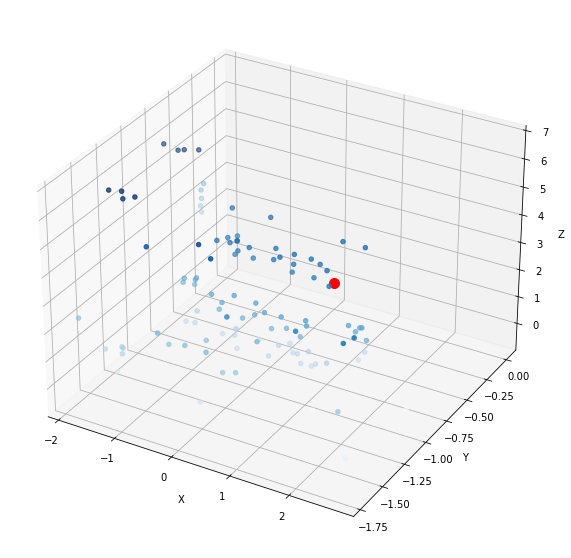

In [37]:
## Plot egocentric 3D coords for last scene.

zdata = pos_from_camera[:,2]
xdata = pos_from_camera[:,0]
ydata = pos_from_camera[:,1]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Blues')
ax.scatter3D(0, 0, 0, color="r", s=100)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

### Add fixated/nearest object info. 

In [11]:
## Load object and feature dataframes. 

gaze_objects = pd.read_csv('data/gaze_objects.csv')
gaze_position = pd.read_csv('data/gaze_position.csv')
object_location = pd.read_csv('data/location/location_all_objects.csv')
# object_shape = pd.read_csv('data/shape/shape_PCA_95_l2/shape_pca_all_objects.csv',index_col=0)
# object_color = pd.read_csv('data/color/color_PCA_95_l2/color_pca_all_objects.csv',index_col=0)

## Add timestamp. 
gaze_objects.insert(2,'timestamp',np.round(gaze_position['timestamp'].values,4))
gaze_objects.insert(3,'frame',gaze_position['frame'])

## Add position info. 
gaze_objects['gaze_x_pos_pixel_vid'] = gaze_position['x_pos_pixel'].values
gaze_objects['gaze_y_pos_pixel_vid'] = gaze_position['y_pos_pixel'].values
gaze_objects['gaze_pos_r_polar'] = np.round(gaze_position['r_polar'].values, decimals=4)
gaze_objects['gaze_pos_theta_polar'] = np.round(gaze_position['theta_polar'].values, decimals=4)
gaze_objects['gaze_x_pos_pixel_360'] = gaze_position['x_pos_pixel_360'].values
gaze_objects['gaze_y_pos_pixel_360'] = gaze_position['y_pos_pixel_360'].values
# gaze_objects['gaze_pos_geo_lat'] = np.round(gaze_position['mu_latitude'].values, decimals=4)
# gaze_objects['gaze_pos_geo_long'] = np.round(gaze_position['beta_longitude'].values, decimals=4)

## Replace invalid values with NaN.
gaze_objects = gaze_objects.replace(-999, np.nan)

In [2]:
sample = gaze_objects[gaze_objects['participant'] == participant_list[0]]
sample.column

NameError: name 'gaze_objects' is not defined

#### Location.
Here, we need to deal with the issue of object clones. The object label (HitObject) is obtained by casting a ray in the Unity scene from the origin of gaze (GazeLocation) in the direction of gaze (GazeDirection), and recording the label of the object hit by the ray. 

At the moment, this information is ambiguous with respect to the scene information files, because each scene may contain several clones of the same object (e.g. one scene may have 2 rubber ducks). To record the location associated with the object being fixated at a given time, we loop over scenes and objects, and record info of the clone nearest to the current gaze position. 

This means that: 
* For times when the ray hit a valid object, the "nearest_obj" column should be redundant with the "object" column, and the "nearest_obj" location columns correspond to the object being fixated.  
* For times when the ray hit an invalid object, (ie not in the set of possible targets/distractors; things like walls and tables), this allows us to record the properties of the nearest object (n.b., nearest object might be occluded). 

In [ ]:
## Add nearest fixated object location. 
# Beware, loop takes ~1.5hrs because we need to account for object clones.
t_start = perf_counter()

for s in all_scenes:
    
    print(s)
    
    ## Get objects in this scene. 
    objects_in_scene = np.unique(object_location[object_location['scene'] == s]['object'].values)
    
    for o in objects_in_scene:
        
        ## Subset gaze data for which we were in the scene and looking at object o.  
        gaze_objects_scene_obj = gaze_objects[(gaze_objects['scene'] == s) & (gaze_objects['object'] == o)]
        
        ## Check if people never looked at the object in a given scene. 
        if len(gaze_objects_scene_obj) > 0:
                
            ## Get position array.
            gaze_pos_scene_obj = np.vstack(gaze_objects_scene_obj[['gaze_x_pos_pixel_360', 'gaze_y_pos_pixel_360']].values)

            ## Get object locations for the object -- note that there may be multiple clones. 
            obj_loc_this_scene = object_location[(object_location['scene'] == s) & (object_location['object'] == o)].reset_index(drop=True)          
            obj_pos_this_scene = obj_loc_this_scene[['x_pos_pixel_360', 'y_pos_pixel_360']].values

            ## Get properties of the nearest clone. 
            nearest_obj_idx = np.argmin(cdist(gaze_pos_scene_obj,obj_pos_this_scene),1)
            locs = obj_loc_this_scene.loc[nearest_obj_idx]
            
            ## Get object index within scene file (to help us distinguish object clones later).
            this_scene = object_location[(object_location['scene'] == s)]

            ## Fill into dataframe. 
            row_index = gaze_objects_scene_obj.index
            gaze_objects.loc[row_index, 'nearest_obj'] = locs['object'].values
            gaze_objects.loc[row_index, 'nearest_obj_idx_within_scene'] = locs['object_idx'].values
            gaze_objects.loc[row_index, 'nearest_obj_loc_r_polar'] = np.round(locs['r_polar'].values, decimals=4)
            gaze_objects.loc[row_index, 'nearest_obj_loc_theta_polar'] = np.round(locs['theta_polar'].values, decimals=4)
            gaze_objects.loc[row_index, 'nearest_obj_x_loc_pixel_360'] = locs['x_pos_pixel_360'].values
            gaze_objects.loc[row_index, 'nearest_obj_y_loc_pixel_360'] = locs['y_pos_pixel_360'].values

    ## Subset gaze data for which people were not looking at valid objects. 
    gaze_objects_scene_other = gaze_objects[(gaze_objects['scene'] == s) & pd.notna(gaze_objects['object']) & (gaze_objects['valid'] == 0)]

    ## Get position array. 
    gaze_pos_scene_other = np.vstack(gaze_objects_scene_other[['gaze_x_pos_pixel_360', 'gaze_y_pos_pixel_360']].values)
    all_obj_loc_this_scene = object_location[(object_location['scene'] == s)].reset_index(drop=True)    
    all_obj_pos_this_scene = all_obj_loc_this_scene[['x_pos_pixel_360', 'y_pos_pixel_360']].values
    
    ## Get properties of the object nearest to current gaze point.
    nearest_idx = np.argmin(cdist(gaze_pos_scene_other, all_obj_pos_this_scene),1)
    locs = all_obj_loc_this_scene.loc[nearest_idx].reset_index(drop=True)
    
    ## Fill into dataframe. 
    row_index = gaze_objects_scene_other.index
    gaze_objects.loc[row_index, 'nearest_obj'] = locs['object'].values
    gaze_objects.loc[row_index, 'nearest_obj_idx_within_scene'] = locs['object_idx'].values
    gaze_objects.loc[row_index, 'nearest_obj_loc_r_polar'] = np.round(locs['r_polar'].values, decimals=4)
    gaze_objects.loc[row_index, 'nearest_obj_loc_theta_polar'] = np.round(locs['theta_polar'].values, decimals=4)
    gaze_objects.loc[row_index, 'nearest_obj_x_loc_pixel_360'] = locs['x_pos_pixel_360'].values
    gaze_objects.loc[row_index, 'nearest_obj_y_loc_pixel_360'] = locs['y_pos_pixel_360'].values
    
t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds')  

In [ ]:
# Intermediary save.
gaze_objects.to_csv('data/gaze_objects_temp.csv', index=False)

In [ ]:
# Intermediary load.
# ~ 11 seconds
t_start = perf_counter()
gaze_objects = pd.read_csv('data/gaze_objects_temp.csv')
t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds') 

In [ ]:
gaze_objects = gaze_objects[gaze_objects['condition'] == 'No'].reset_index(drop=True)
gaze_objects.groupby(['participant'])['trial'].value_counts()

#### Shape & color. 

In [ ]:
## Keep only first 3 PCs in shape. 
all_objects = object_shape.index.values
shape_pcs_to_drop = np.arange(3,82).tolist()
shape_pcs_to_drop = [str(i) for i in shape_pcs_to_drop]
object_shape = object_shape.drop(labels=shape_pcs_to_drop,axis=1)
object_shape.columns = ['shape_pc1', 'shape_pc2', 'shape_pc3']
# object_shape.insert(0, 'object', all_objects)

## Keep only first 3 PCs in color. 
color_pcs_to_drop = np.arange(3,30).tolist()
color_pcs_to_drop = [str(i) for i in color_pcs_to_drop]
object_color = object_color.drop(labels=color_pcs_to_drop,axis=1)
object_color.columns = ['color_pc1', 'color_pc2', 'color_pc3']
# object_color.insert(0, 'object', all_objects)

## Add to dataframe. 
gaze_objects_of = gaze_objects.merge(object_shape, how='left', left_on='nearest_obj', right_on='object')
gaze_objects_of = gaze_objects_of.merge(object_color, how='left', left_on='nearest_obj', right_on='object')

gaze_objects['obj_shape_1'] = np.round(gaze_objects_of['shape_pc1'].values, decimals=4)
gaze_objects['obj_shape_2'] = np.round(gaze_objects_of['shape_pc2'].values, decimals=4)
gaze_objects['obj_shape_3'] = np.round(gaze_objects_of['shape_pc3'].values, decimals=4)
gaze_objects['obj_color_1'] = np.round(gaze_objects_of['color_pc1'].values, decimals=4)
gaze_objects['obj_color_2'] = np.round(gaze_objects_of['color_pc2'].values, decimals=4)
gaze_objects['obj_color_3'] = np.round(gaze_objects_of['color_pc3'].values, decimals=4)

### Add target features.

#### Location. 

In [ ]:
for s in all_scenes:

    ## Get target in this scene (always the first object listed in the scene info).
    scene_target_info = object_location[object_location['scene'] == s].reset_index().loc[0]
    target_name = scene_target_info['object']
    
    ## Get gaze samples for this scene.
    gaze_objects_scene = gaze_objects[(gaze_objects['scene'] == s)]
    
    ## Fill into dataframe. 
    row_index = gaze_objects_scene.index
    gaze_objects.loc[row_index, 'target_loc_r_polar'] = np.round(scene_target_info['r_polar'], decimals=4)
    gaze_objects.loc[row_index, 'target_loc_theta_polar'] = np.round(scene_target_info['theta_polar'], decimals=4)
    gaze_objects.loc[row_index, 'target_x_loc_pixel_360'] = scene_target_info['x_pos_pixel_360']
    gaze_objects.loc[row_index, 'target_y_loc_pixel_360'] = scene_target_info['y_pos_pixel_360']

#### Shape & color. 

In [ ]:
gaze_objects_tf = gaze_objects.merge(object_shape, how='left', left_on='target', right_on='object')
gaze_objects_tf = gaze_objects_tf.merge(object_color, how='left', left_on='target', right_on='object')

gaze_objects['target_shape_1'] = np.round(gaze_objects_tf['shape_pc1'].values, decimals=4)
gaze_objects['target_shape_2'] = np.round(gaze_objects_tf['shape_pc2'].values, decimals=4)
gaze_objects['target_shape_3'] = np.round(gaze_objects_tf['shape_pc3'].values, decimals=4)
gaze_objects['target_color_1'] = np.round(gaze_objects_tf['color_pc1'].values, decimals=4)
gaze_objects['target_color_2'] = np.round(gaze_objects_tf['color_pc2'].values, decimals=4)
gaze_objects['target_color_3'] = np.round(gaze_objects_tf['color_pc3'].values, decimals=4)

### Save.

In [ ]:
# ~2 min
t_start = perf_counter()
gaze_objects['scene'] = gaze_objects['scene'].astype(str) 
gaze_objects.to_csv('data/gaze_objects_with_features.csv', index=False)
t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds') 

In [ ]:
gaze_objects.head(10)

### Load.

To-do: move the below to the model-free analysis code. 

In [ ]:
# ~ 11 seconds
t_start = perf_counter()
gaze_objects = pd.read_csv('data/gaze_objects_with_features.csv')
t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds') 

### What is the distribution of samples across valid objects? 

Of the times people look at valid objects, how often are particular objects looked at by category? 

In [ ]:
df = gaze_objects[gaze_objects['valid'] == 1].groupby('object', as_index=False)['valid'].count()

fig, ax = plt.subplots(figsize=(25,8));
sns.barplot(x=df['object'], y=df['valid']/np.sum(df['valid'].values), palette="deep");
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Object', fontsize=30)
plt.ylabel('Percent looked at', fontsize=30)
sns.despine()

### How often were different objects the target? 

In [ ]:
## Pivot to one row per trial. 
df = gaze_objects.groupby(['participant','trial'])['target'].value_counts().reset_index(level=(0,1))

## Get target label for each trial and count.
df['target_id'] = df.index.values
df = df.groupby('target_id', as_index = False).count()

## Add objects that were never the target. 
df_aux = pd.DataFrame({"target_id": never_targets, 
                       "participant": 0, 
                       "trial": 0, 
                       "target": 0})
df = df.append(df_aux).sort_values('target_id')

fig, ax = plt.subplots(figsize=(25,8));
sns.barplot(x=df['target_id'], y=df['target']/23, palette='deep');
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Object', fontsize=30)
plt.ylabel('Trials per participant', fontsize=30)
sns.despine()

### Percent correct by target: are certain targets easier than others? 

In [ ]:
## Pivot to one row per trial.
df = gaze_objects.groupby(['participant','trial','target'])['correct'].value_counts().reset_index(level=(0,1,2))
df['correct_new'] = df.index.values

## Average by object within participant.
df = df.groupby(['participant', 'target'], as_index=False)['correct_new'].mean()

## Average across participants and sort -- this loses the between-subjects error.
df = df.groupby(['target'], as_index=False)['correct_new'].mean().sort_values(['correct_new'])

fig, ax = plt.subplots(figsize=(25,8));
sns.barplot(x="target", y="correct_new", data=df,  palette="Blues_d")
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Object', fontsize=30)
plt.ylabel('Percent correct', fontsize=30)
plt.axhline(y=df['correct_new'].mean(), color='k', linestyle='--')
sns.despine()

### How does the sample distribution change as a function of target? 

Need to figure out how to control by distractor presence: currently the count is only over all objects that people could have looked at, irrespective of whether the object was present in the trial or not. 

In [ ]:
## Count number of samples.
df = gaze_objects.loc[(gaze_objects['target'] == 'Pear') & (gaze_objects['valid'] == 1)]
df = df.groupby('object', as_index=False)['valid'].count()

## Get objects that were not examined for this target. 
not_examined = np.setdiff1d(unique_objects, df['object'])

## Add unexamined objects.
df_aux = pd.DataFrame({"object": not_examined, "valid": 0}) 
df = df.append(df_aux)

## Sort alphabetically.
df = df.sort_values('object')

fig, ax = plt.subplots(figsize=(25,8));
sns.barplot(x=df['object'], y=df['valid']/np.sum(df['valid'].values), palette="deep");
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Object', fontsize=30)
plt.ylabel('Percent looked at', fontsize=30)
ax.set_ylim(0,0.6)
sns.despine()